# figures for the carbon talk

In [1]:
%matplotlib inline
import os
import glob
import seaborn as sns
import numpy as np
import scipy as sp
import pandas as pd
import scipy.io
import numpy.fft
import scipy.signal
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import linregress
from sklearn import linear_model
mpl.rcParams['figure.figsize'] = (16, 10)

In [3]:
subjoa = np.load('/Volumes/CANlab/Projects/Aging/Study 120/Jorge/2016-10-15-18-01-00.957229/subjoa-2-24-ransac.npy').item()
subjya = np.load('/Volumes/CANlab/Projects/Aging/Study 120/Jorge/2016-10-15-18-01-00.957229/subjya-2-24-ransac.npy').item()

In [7]:
subjoa.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 'eyesO_psd', 'eyesO_slope', 'f_rm_alpha', 'eyesC_fitline', 'eyesC_psd', 'eyesC_slope', 'eyesO_fitline', 'f', 'time_computed', 'nbsubj'])

In [8]:
subjoa[0].keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 'age', 31, 32, 33, 34, 35, 'srate', 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 'nbchan', 'sex', 30, 'eyesO_psd', 'eyesO_slope', 'eyesC_psd_rm_alpha', 'eyesC_fitline', 36, 'data', 'eyesC_psd', 'eyesC_slope', 'eyesO_fitline', 'eyesO_psd_rm_alpha', 'class', 'name', 'events'])

In [10]:
channels = ["PCC","PCCr_DMN_w","PCCv_DMN_w","PCCh_DMN_w","mPFC","mPFCr_DMN_w","mPFCv_DMN_w","mPFCh_DMN_w","LAG","LAGr_DMN_w","LAGv_DMN_w","LAGh_DMN_w","RAG","RAGr_DMN_w","RAGv_DMN_w","RAGh_DMN_w","LLatT","LLatTe_N_w","LLatTe_N_w","LLatTe_N_w","RLatT","RLatTe_N_w","RLatTe_N_w","RLatTe_N_w","NoiseL1","NoiseL1_N_w","NoiseL1_N_w","NoiseL1_N_w","NoiseR1","NoiseR1_N_w","NoiseR1_N_w","NoiseR1_N_w","NoiseL2","NoiseL2_N_w","NoiseL2_N_w","NoiseL2_N_w","NoiseR2","NoiseR2_N_w","NoiseR2_N_w","NoiseR2_N_w","NoiseM1","NoiseM1_N_w","NoiseM1_N_w","NoiseM1_N_w","NoiseM2","NoiseM2_N_w","NoiseM2_N_w","NoiseM2_N_w"]
for i in range(len(channels)):
    print("{} | {}".format(i, channels[i]))

0 | PCC
1 | PCCr_DMN_w
2 | PCCv_DMN_w
3 | PCCh_DMN_w
4 | mPFC
5 | mPFCr_DMN_w
6 | mPFCv_DMN_w
7 | mPFCh_DMN_w
8 | LAG
9 | LAGr_DMN_w
10 | LAGv_DMN_w
11 | LAGh_DMN_w
12 | RAG
13 | RAGr_DMN_w
14 | RAGv_DMN_w
15 | RAGh_DMN_w
16 | LLatT
17 | LLatTe_N_w
18 | LLatTe_N_w
19 | LLatTe_N_w
20 | RLatT
21 | RLatTe_N_w
22 | RLatTe_N_w
23 | RLatTe_N_w
24 | NoiseL1
25 | NoiseL1_N_w
26 | NoiseL1_N_w
27 | NoiseL1_N_w
28 | NoiseR1
29 | NoiseR1_N_w
30 | NoiseR1_N_w
31 | NoiseR1_N_w
32 | NoiseL2
33 | NoiseL2_N_w
34 | NoiseL2_N_w
35 | NoiseL2_N_w
36 | NoiseR2
37 | NoiseR2_N_w
38 | NoiseR2_N_w
39 | NoiseR2_N_w
40 | NoiseM1
41 | NoiseM1_N_w
42 | NoiseM1_N_w
43 | NoiseM1_N_w
44 | NoiseM2
45 | NoiseM2_N_w
46 | NoiseM2_N_w
47 | NoiseM2_N_w


So we need:
- 0: PCC
- 4: mPFC
- 8: LAG
- 12: RAG
- 16: LLatT
- 20: RLatT

(0.2, 1.3)

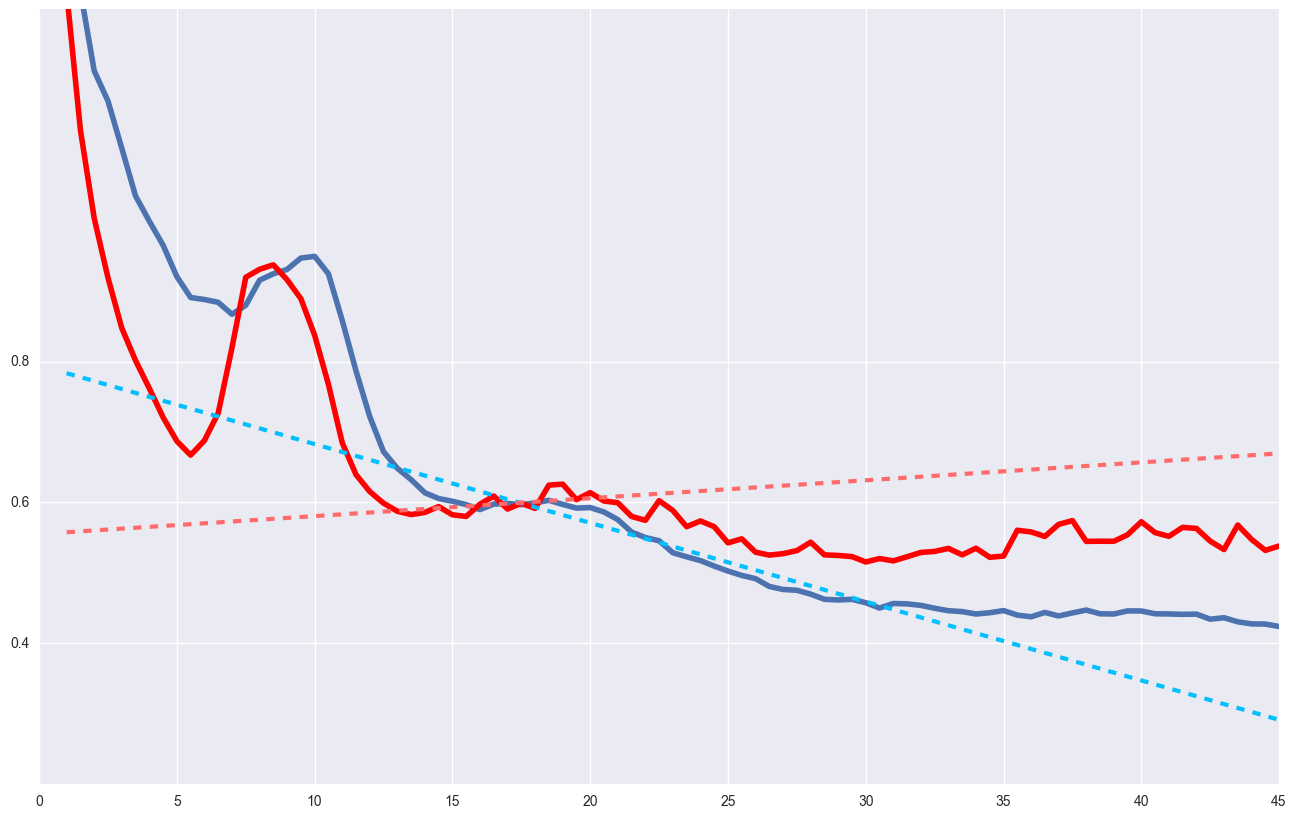

In [71]:
def ransac_slope(f, psd, lofreq, hifreq):
    """
    Robustly fits line to the PSD, using the RANSAC algorithm. 
    Returns slope and fit line.
    """
    model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression())
    model_ransac.fit(f[lofreq*2:hifreq*2], np.log10(psd[lofreq*2:hifreq*2]))
    fit_line = model_ransac.predict(f)
    return model_ransac.estimator_.coef_[0] * (10**2), fit_line

def remove_freq_buffer(data, lofreq, hifreq):
    """
    Removes a frequency buffer from a PSD or frequency vector.
    """
    data = np.delete(data, range(lofreq*2, hifreq*2))
    return data.reshape(len(data), 1)

def linreg_slope(f, psd, lofreq, hifreq):
    """
    Fits line to the PSD, using regular linear regression.
    Returns slope and fit line.
    """
    model = linear_model.LinearRegression()
    model.fit(f[lofreq*2:hifreq*2], np.log10(psd[lofreq*2:hifreq*2]))
    fit_line = model.predict(f)
    return model.coef_[0] * (10**2), fit_line

older_adults = ['MCI_Control', 'SA_Control']#, 'MCI', 'SA']
dmnch = [0, 4, 8, 12, 16, 20]
for i in range(subjoa['nbsubj']):
    subjoa[i]['avg_dmn'] = np.mean([subjoa[i][ch]['eyesC_psd'] for ch in dmnch], axis=0)
for i in range(subjya['nbsubj']):
    subjya[i]['avg_dmn'] = np.mean([subjya[i][ch]['eyesC_psd'] for ch in dmnch], axis=0)

ya_psd = np.mean([subjya[i]['avg_dmn'] for i in range(subjya['nbsubj'])], axis=0)
oa_psd = np.mean([subjoa[i]['avg_dmn'] for i in range(subjoa['nbsubj']) if subjoa[i]['class'] in older_adults], axis=0)

ya_psd_rm = remove_freq_buffer(ya_psd, 7, 14)
oa_psd = remove_freq_buffer(oa_psd, 7, 14)
f      = remove_freq_buffer(subjoa['f'], 0, 1)

ya_psd = np.sqrt(ya_psd)
oa_psd = np.sqrt(oa_psd)

ya_slope, ya_fitline = ransac_slope(f, ya_psd, 5, 24)
oa_slope, oa_fitline = ransac_slope(f, oa_psd, 5, 24)

sns.set_style('darkgrid')
plt.plot(f, np.log10(ya_psd), label='YA PSD', linewidth='4.0')
plt.plot(f, np.log10(oa_psd), label='OA PSD', color='red', linewidth='4.0')
plt.plot(f, ya_fitline, '--', color='#00BFFF', linewidth='3.0')
plt.plot(f, oa_fitline, '--', color='#FF6A6A', linewidth='3.0')
# plt.xlabel(r'Frequency $(Hz)$')
# plt.ylabel(r'$\log10{(\mu V)}$')
mpl.rc('xtick', labelsize=10) 
mpl.rc('ytick', labelsize=10) 
# font = {'family' : 'normal',
#         'size'   : 20}

# mpl.rc('font', **font)

plt.yticks(np.arange(-0.8, 1, 0.2))

plt.xlim([0, 45]); plt.ylim([0.2, 1.3])
    

    
    
    
# oa_avg_dmn_psd = np.mean([subjoa[i]['avg_dmn'] for i in range(subjoa['nbsubj']) if subjoa[i]['class'] in older_adults], axis=0)
# ya_avg_dmn_psd = np.mean([subjya[i]['avg_dmn'] for i in range(subjya['nbsubj'])], axis=0)
# ya_psd = ya_avg_dmn_psd
# oa_psd = oa_avg_dmn_psd
# f = subjoa['f']
# sns.set_style('darkgrid')
# plt.plot(f, np.log10(ya_psd), label='YA PSD', linewidth='4.0')
# plt.plot(f, np.log10(oa_psd), label='OA PSD', color='red', linewidth='4.0')
# # plt.plot(f, ya_fitline, '--', color='#00BFFF', linewidth='3.0')
# # plt.plot(f, oa_fitline, '--', color='#FF6A6A', linewidth='3.0')
# plt.xlabel(r'Frequency $(Hz)$')
# plt.ylabel(r'$\log10{(\mu V)}$')
# mpl.rc('xtick', labelsize=10) 
# mpl.rc('ytick', labelsize=10) 
# # font = {'family' : 'normal',
# #         'size'   : 20}

# # mpl.rc('font', **font)

# # plt.yticks(np.arange(-0.8, 1, 0.2))

# plt.xlim([0, 25]);

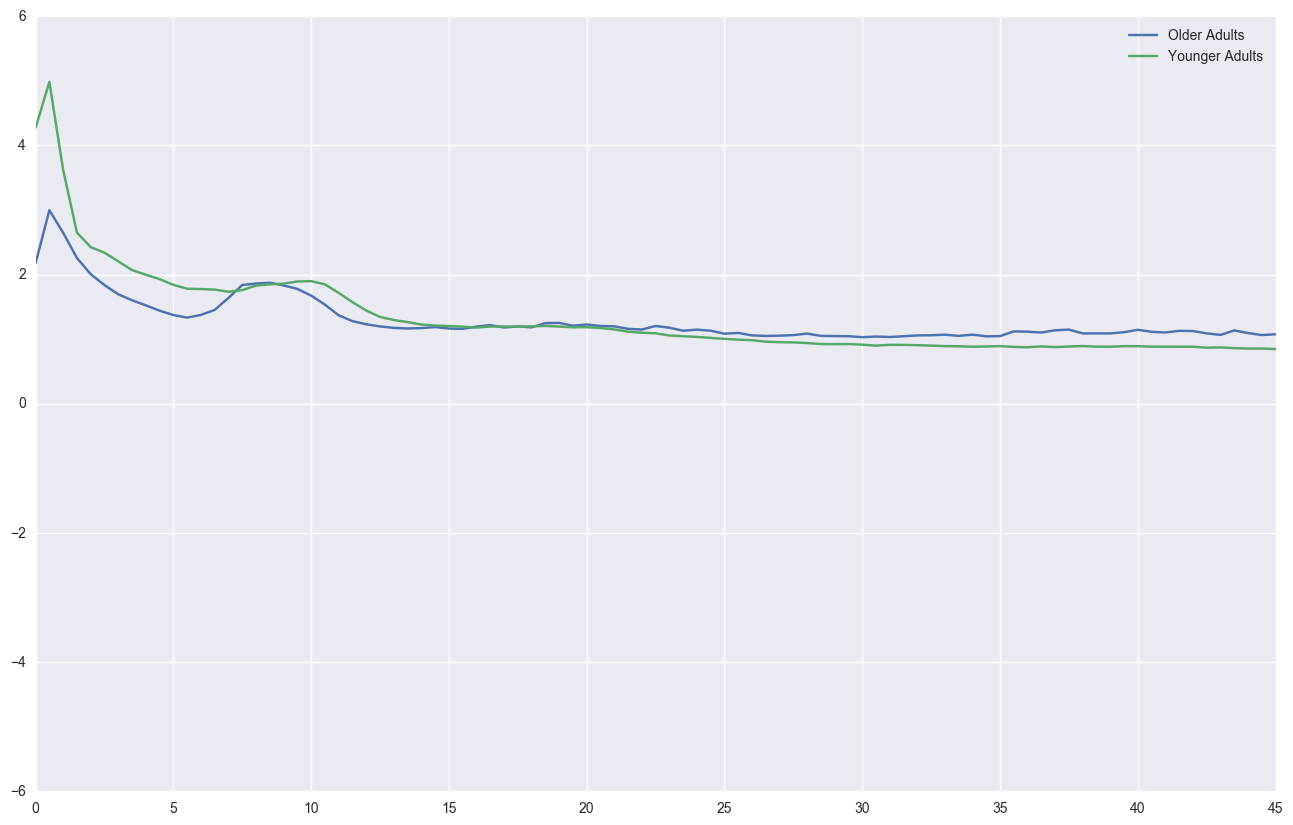

In [34]:
plt.plot(subjoa['f'], np.log10(oa_avg_dmn_psd), label='Older Adults')
plt.plot(subjya['f'], np.log10(ya_avg_dmn_psd), label='Younger Adults')
plt.xlim([0, 45]); plt.legend()

(0, 50)

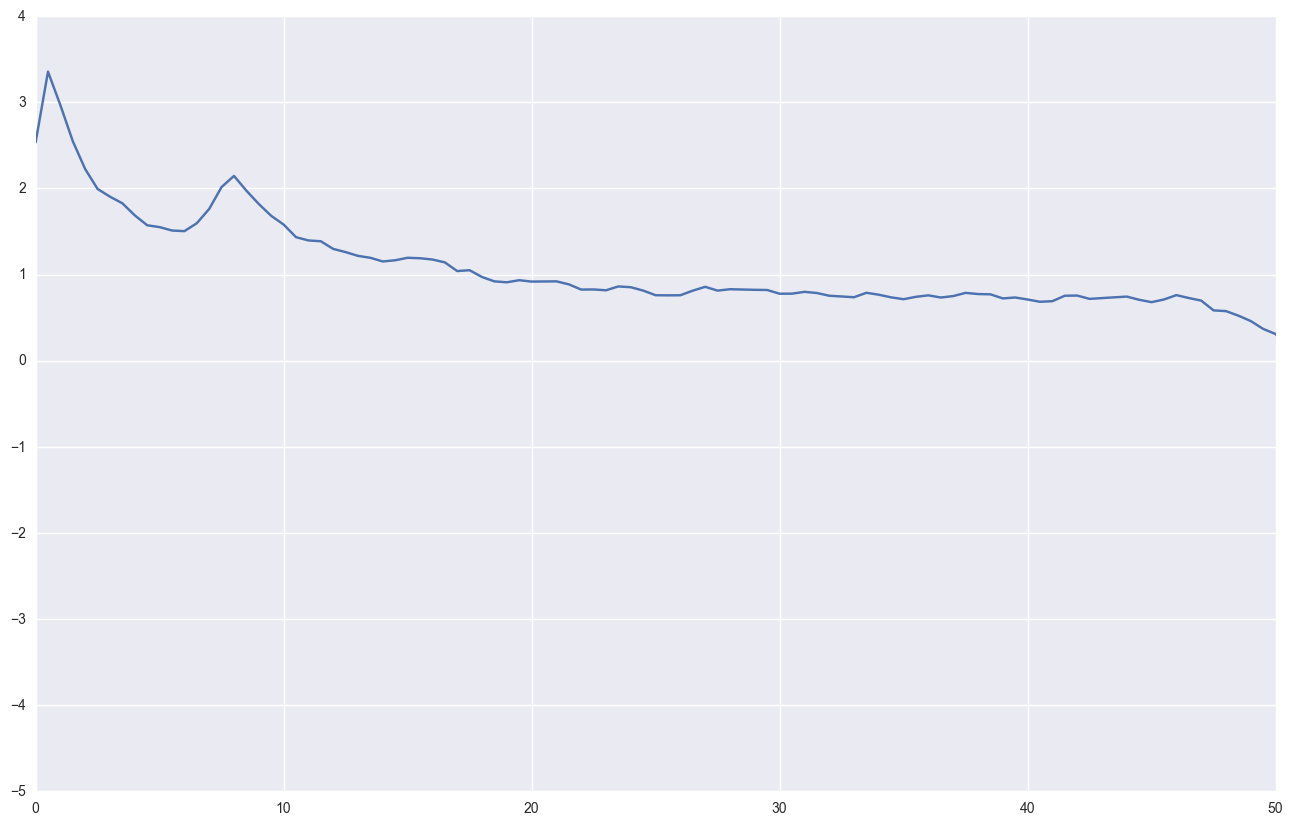

In [13]:
plt.plot(subjoa['f'], np.log10(psd)); plt.xlim([0, 50])

In [19]:
subjoa[0]['class']

'SA_Control'

In [74]:
len([subjoa[i] for i in range(subjoa['nbsubj']) if subjoa[i]['class'] in older_adults])

28